
## Description
This notebook aims to check the accuracy and R-squared score for different supervised learning models that aim to decide whether each player in the dataframe is or isnt a shooting guard

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, KFold, train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.inspection import permutation_importance

In [2]:
df = pd.read_csv("2021-2022NBAPlayerStats-Regular.csv", sep=';')
df.head()
df.shape

(812, 30)

In [3]:
df.describe()

,Rk,Age,G,GS,MP,FG,FGA,FG%,3P,3PA,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
count,812.000000,812.000000,812.000000,812.000000,812.000000,812.000000,812.000000,812.000000,812.000000,812.000000,...,812.000000,812.000000,812.000000,812.000000,812.000000,812.000000,812.000000,812.000000,812.000000,812.000000
mean,304.501232,26.051724,36.704433,16.672414,18.265394,2.869951,6.386576,0.426235,0.871305,2.560591,...,0.658267,0.812931,2.519828,3.331650,1.808251,0.582759,0.353571,0.978695,1.564655,7.812438
std,172.637333,4.059640,25.899099,23.817195,9.648292,2.223988,4.651121,0.148525,0.841935,2.205642,...,0.283491,0.744196,1.790656,2.352818,1.838080,0.425452,0.360811,0.817941,0.826783,6.138077
min,1.000000,19.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,158.750000,23.000000,12.000000,0.000000,10.500000,1.200000,3.000000,0.380750,0.200000,0.800000,...,0.600000,0.300000,1.300000,1.700000,0.500000,0.300000,0.100000,0.400000,1.000000,3.300000
50%,300.500000,25.000000,36.500000,4.000000,17.500000,2.400000,5.150000,0.439500,0.700000,2.050000,...,0.750000,0.600000,2.300000,2.900000,1.200000,0.500000,0.300000,0.800000,1.600000,6.300000
75%,459.000000,29.000000,61.000000,25.000000,25.725000,3.900000,8.725000,0.500000,1.400000,3.900000,...,0.838000,1.100000,3.400000,4.400000,2.400000,0.900000,0.500000,1.300000,2.200000,10.600000
max,605.000000,41.000000,82.000000,82.000000,43.500000,11.400000,21.800000,1.000000,4.500000,11.700000,...,1.000000,4.600000,11.000000,14.700000,10.800000,2.500000,2.800000,4.800000,5.000000,30.600000


## Cleaning and standardizing data
dataframe does not contain any missing data - therefore, no filling or dropping of na will be needed!
As i am creating a binary classifier, some categorical data will be dropped (teams), as well as data useless for this specific analysis (name). As it can be seen in the table below, the 
When it comes to the values, standardization is needed, since they fluctuate a lot and lack of centering that can lead to incorrectly valuing more specific attributes

In [4]:
df.isna().sum().sort_values()

Rk        0
Player    0
Pos       0
Age       0
Tm        0
G         0
GS        0
MP        0
FG        0
FGA       0
FG%       0
3P        0
3PA       0
3P%       0
2P        0
2PA       0
2P%       0
eFG%      0
FT        0
FTA       0
FT%       0
ORB       0
DRB       0
TRB       0
AST       0
STL       0
BLK       0
TOV       0
PF        0
PTS       0
dtype: int64

In [5]:
df.columns

Index(['Rk', 'Player', 'Pos', 'Age', 'Tm', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%',
       '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%',
       'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS'],
      dtype='object')

In [6]:
name_labels = df["Player"]
df.drop(['Tm','Player','Rk'], axis=1, inplace=True)
df["point_guard"] = df["Pos"] == "PG"
df = df.drop("Pos", axis=1)

In [7]:
df

,Age,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,point_guard
0,22,73,28,23.6,3.6,8.3,0.439,0.8,2.1,0.359,...,2.0,4.5,6.5,1.1,0.5,0.6,1.2,2.1,9.1,False
1,28,76,75,26.3,2.8,5.1,0.547,0.0,0.0,0.000,...,4.6,5.4,10.0,3.4,0.9,0.8,1.5,2.0,6.9,False
2,24,56,56,32.6,7.3,13.0,0.557,0.0,0.1,0.000,...,2.4,7.6,10.1,3.4,1.4,0.8,2.6,3.1,19.1,False
3,21,32,0,11.3,1.7,4.1,0.402,0.2,1.5,0.125,...,1.0,1.7,2.7,0.7,0.2,0.3,0.5,1.1,4.1,False
4,36,47,12,22.3,5.4,9.7,0.550,0.3,1.0,0.304,...,1.6,3.9,5.5,0.9,0.3,1.0,0.9,1.7,12.9,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
807,33,26,0,18.3,2.6,5.5,0.465,0.7,1.7,0.395,...,1.5,2.9,4.4,1.7,1.2,0.4,0.8,1.7,6.3,False
808,23,76,76,34.9,9.4,20.3,0.460,3.1,8.0,0.382,...,0.7,3.1,3.7,9.7,0.9,0.1,4.0,1.7,28.4,True
809,23,56,12,12.6,2.3,4.4,0.526,0.0,0.2,0.091,...,1.5,3.7,5.3,0.9,0.3,0.4,0.7,1.5,5.3,False
810,29,27,0,13.1,1.9,3.3,0.567,0.0,0.1,0.000,...,1.9,2.8,4.6,0.8,0.3,0.2,0.7,2.1,5.2,False


## Splitting and scaling data
Now, the dataset will be divided between test and train groups and their values will be standardized(seen that we dont want to over value specific attributes)

In [8]:
X = df.drop("point_guard", axis=1).values
y = df["point_guard"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10)

In [9]:
print(np.mean(X), np.std(X))

5.426657303902994 11.578919353936433


In [10]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("before standardizing: ",np.mean(X), np.std(X))
print("after standardizing: ", np.mean(X_train_scaled), np.std(X_train_scaled))

before standardizing:  5.426657303902994 11.578919353936433
after standardizing:  1.9744777297868138e-16 1.0


## Hyperparameter Tuning
A cross validation grid search will be done on each model in order to define the best parameters to be used on them.

Then, a cross validation is done with said paremeters so that its performance can be verified

In [11]:

kf = KFold(n_splits=6, random_state=12, shuffle=True)
param_grid = {'n_neighbors': [3, 5, 6, 9, 11, 15, 21],
              "metric": ["euclidean", "manhattan"]}
knn = KNeighborsClassifier()
knn_cv = GridSearchCV(knn, param_grid=param_grid, cv=kf)
knn_cv.fit(X_train_scaled, y_train)
print(knn_cv.best_params_, knn_cv.best_score_)


{'metric': 'euclidean', 'n_neighbors': 11} 0.8440432278521969


In [12]:
knn = KNeighborsClassifier(n_neighbors=11, metric='euclidean')
knn_cv_results = cross_val_score(knn, X_train_scaled, y_train, cv=kf)
print(knn_cv_results)

[0.85294118 0.88235294 0.7745098  0.83168317 0.88118812 0.84158416]


In [13]:
params = {"C" :   [.001, .01, .1, 1, 10]}
logreg = LogisticRegression()
logreg_cv = GridSearchCV(logreg, param_grid=params, cv=kf)
logreg_cv.fit(X_train_scaled, y_train)
print(logreg_cv.best_params_, logreg_cv.best_score_)

{'C': 10} 0.8785187342263638


In [14]:
logreg = LogisticRegression(C=10)
logreg_cv_results = cross_val_score(logreg, X_train_scaled, y_train, cv = kf)
print(logreg_cv_results)

[0.89215686 0.88235294 0.84313725 0.86138614 0.93069307 0.86138614]


In [15]:
param_grid = {"max_depth": [None, 5, 10, 20, 30],
              "min_samples_split": [2, 5, 10, 20]}
dectree = DecisionTreeClassifier()
dectree_cv = GridSearchCV(dectree, param_grid=param_grid, cv = kf)
dectree_cv.fit(X_train_scaled, y_train)
print(dectree_cv.best_params_, dectree_cv.best_score_)

{'max_depth': 5, 'min_samples_split': 5} 0.8358247589464828


In [16]:
dectree = DecisionTreeClassifier(max_depth=5, min_samples_split=5)
dectree_cv_results = cross_val_score(dectree, X_train_scaled, y_train, cv=kf)
print(dectree_cv_results)

[0.8627451  0.83333333 0.80392157 0.84158416 0.82178218 0.82178218]


##  Plotting for performance visualization

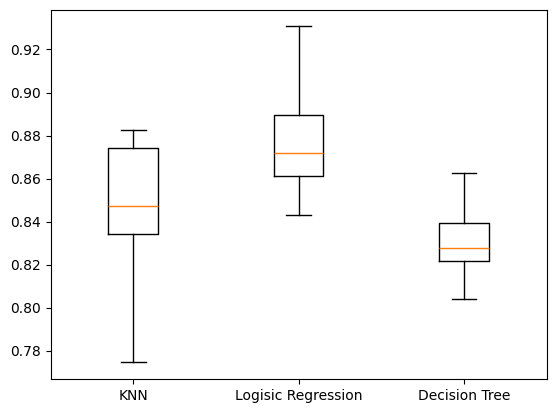

In [17]:
plt.boxplot([knn_cv_results, logreg_cv_results, dectree_cv_results], tick_labels=["KNN", "Logisic Regression", "Decision Tree"])
plt.show()

## Final testing

In [18]:
knn_final = KNeighborsClassifier(n_neighbors=11, metric='euclidean')
knn_final.fit(X_train_scaled, y_train)
predictions = knn_final.predict(X_test_scaled)

print(confusion_matrix(y_true=y_test, y_pred=predictions))
score_knn = knn_final.score(X_test_scaled, y_test)
print(score_knn)

[[161   4]
 [ 28  10]]
0.8423645320197044


In [19]:
logreg_final = LogisticRegression(C=10)
logreg_final.fit(X_train_scaled, y_train)
predictions2 = logreg_final.predict(X_test_scaled)

print(confusion_matrix(y_true=y_test, y_pred=predictions2))
score_logreg = logreg_final.score(X_test_scaled, y_test)
print(score_logreg)

[[155  10]
 [ 16  22]]
0.8719211822660099


In [20]:
dectree_final = DecisionTreeClassifier(max_depth=5, min_samples_split=5)
dectree_final.fit(X_train_scaled, y_train)
predictions3 = dectree_final.predict(X_test_scaled)

print(confusion_matrix(y_true=y_test, y_pred=predictions3))
score_dectree = dectree_final.score(X_test_scaled, y_test)
print(score_dectree)

[[151  14]
 [ 20  18]]
0.8325123152709359


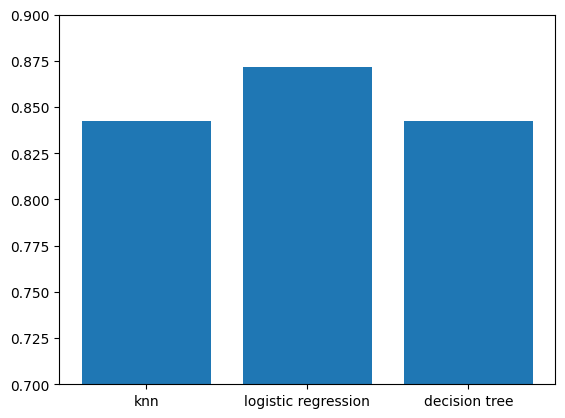

In [21]:
plt.clf()
plt.bar(["knn", "logistic regression", "decision tree"], [score_knn, score_logreg, score_knn])
plt.ylim(0.7, 0.9)
plt.show()

It can be seen that the hyperparameter tuning as well as the cross validation did, in fact, pay off, given that the accuracy was kept at an arguably close rate

## Importance
In this section, the importance of each attribute of the original dataset will be evaluated, pointing out the most revealing columns and how much they are able to affect the final outcome

Note that KNNs do not have an inheriting importance feature (as it is distance based), and so these valued are experimentally determined by using permutation importance, which measures how much accuracy generally drops when a feature is shuffled

In [22]:
feature_names = df.drop("point_guard", axis=1).columns
r = permutation_importance(
    knn_final,
    X_test_scaled,
    y_test,
    n_repeats=30,
    random_state=10,
    scoring="accuracy")

knn_importance = pd.DataFrame({
    "feature": feature_names,
    "importance": r.importances_mean
    })

print(knn_importance.sort_values("importance", ascending=False))

   feature  importance
20     AST    0.040722
0      Age    0.009360
14      FT    0.009360
22     BLK    0.009031
17     ORB    0.008539
21     STL    0.007061
15     FTA    0.006240
16     FT%    0.004269
19     TRB    0.004105
18     DRB    0.003612
13    eFG%    0.002791
8      3PA    0.002627
24      PF    0.002299
23     TOV    0.002135
7       3P    0.001149
12     2P%    0.000821
25     PTS    0.000493
3       MP    0.000328
10      2P    0.000328
2       GS   -0.000164
9      3P%   -0.000821
11     2PA   -0.001149
4       FG   -0.001478
1        G   -0.001642
6      FG%   -0.003777
5      FGA   -0.004105


In [23]:
coef_logreg = logreg_final.coef_[0]
importance_logreg = np.abs(coef_logreg)

logreg_importance = pd.DataFrame({
    "feature" : feature_names,
    "coefficient" : coef_logreg,
    "importance" : importance_logreg
})#.sort_values(by=importance_logreg, ascending = False)

print(logreg_importance.sort_values("importance", ascending=False))

   feature  coefficient  importance
11     2PA     3.376226    3.376226
20     AST     2.757329    2.757329
4       FG    -2.113459    2.113459
10      2P    -2.042903    2.042903
5      FGA     1.742750    1.742750
17     ORB    -1.507334    1.507334
19     TRB    -1.501418    1.501418
7       3P     1.400100    1.400100
25     PTS    -1.393532    1.393532
8      3PA    -1.364527    1.364527
13    eFG%     1.359199    1.359199
18     DRB    -0.917208    0.917208
6      FG%    -0.767809    0.767809
14      FT    -0.575548    0.575548
23     TOV     0.543275    0.543275
9      3P%    -0.478835    0.478835
24      PF    -0.259274    0.259274
15     FTA    -0.252748    0.252748
21     STL     0.188416    0.188416
16     FT%     0.162231    0.162231
0      Age    -0.126994    0.126994
2       GS    -0.066176    0.066176
3       MP    -0.052345    0.052345
22     BLK    -0.048892    0.048892
1        G     0.036755    0.036755
12     2P%    -0.030812    0.030812


In [24]:
dectree_importance = pd.DataFrame({
    "feature": feature_names,
    "importance" : dectree_final.feature_importances_
})

print(dectree_importance.sort_values("importance", ascending=False))

   feature  importance
20     AST    0.365342
18     DRB    0.122687
17     ORB    0.121143
6      FG%    0.097333
5      FGA    0.055993
0      Age    0.051939
15     FTA    0.040284
10      2P    0.033277
12     2P%    0.030041
21     STL    0.027089
9      3P%    0.026460
13    eFG%    0.021098
11     2PA    0.007315
7       3P    0.000000
2       GS    0.000000
1        G    0.000000
3       MP    0.000000
4       FG    0.000000
8      3PA    0.000000
14      FT    0.000000
16     FT%    0.000000
19     TRB    0.000000
22     BLK    0.000000
23     TOV    0.000000
24      PF    0.000000
25     PTS    0.000000


It is very interesting to visualize which attributes have more effect on the final decision, and verify that all three models end up with a somewhat similar list of importances:

Assistences are constantly seen on top - given that point guards organize the offense and tend to score higher in that field

Higher values in 2 Point attempts and field goal percentages, on the other side, seem to drift away from the possibility of the player being a point guard - seen that centers and forwards tend to play more on the inside of the 3 point line, attempt 2 point shots more and have better performance in them, seen that they are closer to the basket.

## Conclusion
Therefore, it can be seen that, while all three models are somewhat able to correctly predict a basketball player's position based off of their regular season statistics, logistic regression reaches an accuracy of almost 90%!

The models have different ways of working, but it is very interesing to see how they somewhat converge to similar valuations of attributes to reach their conclusion.

I plan to execute similar experiments to other positions so that different characteristics can be verified